# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from functools import partial
import json
import os
from pathlib import Path
from PIL import Image

import cv2
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from pitch_geo import data
from pitch_geo.data import KeyPointsDataset
from pitch_geo.data import read_image_and_keypoints
import pitch_geo.models.augmentation as aug
import pitch_geo.models.metrics
from pitch_geo.models.metrics import NotVisiblePrecision, NotVisibleRecall 
import vis_utils

# Read the data frame

In [2]:
df = pd.read_csv('recruitment_task_pitch_geom/df_keypoints.csv')

I think that there is one row which is mislabeled. There shouldbe 39 instead of 38.

In [3]:
df = df[df['dataset'] == 'train']

In [4]:
key = df.query('kid == 38 and vis != 0')['image_path'].item()
idx1 = df.query(f'kid == 39 and image_path == "{key}"').index
idx2 = df.query(f'kid == 38 and image_path == "{key}"').index
df.loc[idx1, 'x'] = df.loc[idx2, 'x'].item()
df.loc[idx1, 'y'] = df.loc[idx2, 'y'].item()
df.loc[idx1, 'vis'] = df.loc[idx2, 'vis'].item()

Now when 'kid' is 38 the keypoint is always marked as invisible. Drop all the rows with 'kid' == 38 as they don't contain any information.

In [5]:
df = df[df['kid'] != 38]
df['kid'].nunique()

38

Normalize keypoints coordinates (we know that every picture is 1920 by 1080)

In [6]:
# df['x'] = df['x'] / 1920
# df['y'] = df['y'] / 1080

# Define hyperparameters

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 20
NUM_KEYPOINTS = 38 * 2  # 38 pairs each having x and y coordinates
DATA_FOLDER = Path('recruitment_task_pitch_geom')

# Define augmentation

In [8]:
# I have already openCV instlalled. The official albumentations library advices to install it in that way
# !pip install -U albumentations --no-binary qudida,albumentations

In [9]:
# augmentations definitions are moved to package

# Prepare the data loaders

In [10]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        # iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [11]:
def load_image(
    path, image_size, num_channels, interpolation, crop_to_aspect_ratio=False
):
    """Load an image from a path and resize it. Taken from https://github.com/keras-team/keras/blob/v2.10.0/keras/utils/image_dataset.py#L30. """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    if image_size is None:
        return img
    if crop_to_aspect_ratio:
        img = image_utils.smart_resize(
            img, image_size, interpolation=interpolation
        )
    else:
        img = tf.image.resize(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img


annotations_dict = data.df_to_dict2(df)

def get_annotations(image_path):
    # image_path is supposed to be bytes object
    all_annotatios = annotations_dict[image_path.numpy().decode('utf-8')]
    
    # For tranining, we are only interested in keypoints coordinates:
    return all_annotatios['keypoints']

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
# tf.data.experimental.enable_debug_mode()

In [14]:
images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

# train_df = df[df['image_path'].isin(train_paths)]
# val_df = df[~df['image_path'].isin(train_paths)]

train_absolute_paths = [str(DATA_FOLDER / p) for p in  train_paths]
train_paths = tf.data.Dataset.from_tensor_slices(train_paths)
train_files = tf.data.Dataset.from_tensor_slices(train_absolute_paths)

train_images = train_files.map(
    partial(
        load_image, 
        image_size=None, # image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    ),
    num_parallel_calls=AUTOTUNE
)
# train_images = train_images.map(lambda x: x/255, num_parallel_calls=AUTOTUNE) #.cache()

In [15]:
# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = (
    train_paths
    .map(
        lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .map(lambda x: tf.reshape(x, (38, 2)))   # TODO do I need this reshaping or can I do it earlier?
    # .cache()
)

train_ds_ = tf.data.Dataset.zip((train_images, train_labels))

In [16]:
def aug_fn(image, keypoints):
    # print(f'In aug fn')
    kps = KeypointsOnImage(
        [Keypoint(x, y) for x, y in keypoints],
        shape=(1080, 1920)
    )
    image_aug, kps_aug = train_aug(image=image, keypoints=kps)
    kps_aug = np.array([[kp.x, kp.y] for kp in kps_aug]).astype(np.float32)
    # print(f'{image_aug.dtype=}')
    # print(f'{kps_aug.dtype=}')
    return image_aug, kps_aug


def val_aug_fn(image, keypoints):
    # print(f'In aug fn')
    kps = KeypointsOnImage(
        [Keypoint(x, y) for x, y in keypoints],
        shape=(1080, 1920)
    )
    image_aug, kps_aug = test_aug(image=image, keypoints=kps)
    kps_aug = np.array([[kp.x, kp.y] for kp in kps_aug]).astype(np.float32)
    # print(f'{image_aug.dtype=}')
    # print(f'{kps_aug.dtype=}')
    return image_aug, kps_aug

In [17]:
train_ds = (
    train_ds_
    # .shuffle(4000)
    .map(
        lambda image, keypoints: tf.numpy_function(func=aug_fn, inp=[image, keypoints], Tout=[tf.uint8, tf.float32]),
        num_parallel_calls=AUTOTUNE
    )
    .map(lambda image, keypoints: (image, tf.divide(keypoints, tf.constant([IMG_SIZE, IMG_SIZE], tf.float32))), num_parallel_calls=AUTOTUNE)
    .map(lambda image, keypoints: (image, tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS])), num_parallel_calls=AUTOTUNE)
    .map(
        partial(aug.set_shapes, img_shape=(IMG_SIZE, IMG_SIZE, 3), labels_shape=(1, 1, NUM_KEYPOINTS)), 
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .shuffle(406)
    .prefetch(buffer_size=AUTOTUNE)
)
# x, y = next(iter(train_ds))

In [18]:
# x, y = next(batches)
# vis_utils.show_image_with_annotations(x.numpy(), y.numpy().reshape(38, 2), normalized=True)

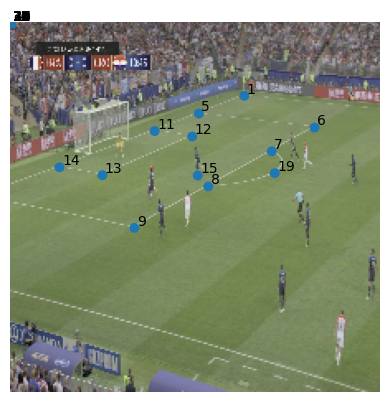

In [19]:
test_batch = next(iter(train_ds))
vis_utils.show_image_with_annotations(test_batch[0].numpy()[0,:] / 255, test_batch[1].numpy()[0,:], dot_radius=3)

In [20]:
%%time
for i, batch in enumerate(train_ds):
    print(f'{i + 1}/{len(train_ds)}', end='\r')
    continue

CPU times: user 53.3 s, sys: 4.69 s, total: 58 s
Wall time: 15 s


In [21]:
# test_batch = next(iter(train_ds))
# vis_utils.show_image_with_annotations(test_batch[0].numpy()[0,:], test_batch[1].numpy()[0,:], dot_radius=3)

In [22]:
val_absolute_paths = [str(DATA_FOLDER / p) for p in  test_paths]
val_paths = tf.data.Dataset.from_tensor_slices(test_paths)
val_files = tf.data.Dataset.from_tensor_slices(val_absolute_paths)

val_images = val_files.map(
    partial(
        load_image, 
        image_size=None,
        num_channels=3,
        interpolation='bilinear'        
    )
)
# val_images = val_images.map(lambda x: x/255).cache()

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
val_labels = val_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16])).map(lambda x: tf.reshape(x, (38, 2)))

val_ds = tf.data.Dataset.zip((val_images, val_labels))

val_ds = (
    val_ds
    .map(
        lambda image, keypoints: tf.numpy_function(func=val_aug_fn, inp=[image, keypoints], Tout=[tf.uint8, tf.float32]),
        num_parallel_calls=AUTOTUNE
    )
    .map(lambda image, keypoints: (image, tf.divide(keypoints, tf.constant([IMG_SIZE, IMG_SIZE], tf.float32))), num_parallel_calls=AUTOTUNE)
    .map(lambda image, keypoints: (image, tf.reshape(keypoints, [1, 1, NUM_KEYPOINTS])), num_parallel_calls=AUTOTUNE)
    .map(
        partial(aug.set_shapes, img_shape=(IMG_SIZE, IMG_SIZE, 3), labels_shape=(1, 1, NUM_KEYPOINTS)), 
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    # .map(keras.applications.mobilenet_v2.preprocess_input, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)

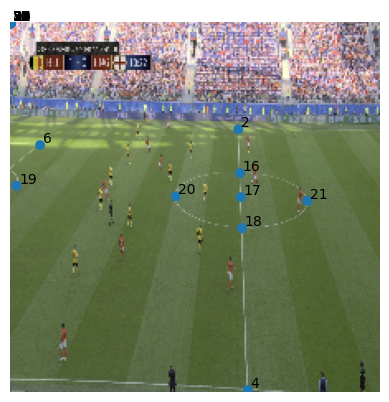

In [23]:
valtest_batch = next(iter(val_ds))
vis_utils.show_image_with_annotations(valtest_batch[0].numpy()[0,:] / 255, valtest_batch[1].numpy()[0,:], dot_radius=3)

In [24]:
valtest_batch[1]

<tf.Tensor: shape=(8, 1, 1, 76), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.615625  , 0.28703704, 0.        ,
          0.        , 0.6411458 , 0.9925925 , 0.        , 0.        ,
          0.07916667, 0.32962963, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.6203125 , 0.40555555, 0.6223958 , 0.47037038, 0.6255208 ,
          0.5546296 , 0.015625  , 0.4398148 , 0.44635418, 0.46851853,
          0.80260414, 0.48055556, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0

# The model

## Model building

In [25]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

## Define callbacks

In [26]:
model_base_path = Path('checkpoints')
checkpoint_template_name = 'weights.{epoch:02d}-{val_loss:.2f}'
training_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = model_base_path / training_timestamp / checkpoint_template_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=Path('logs') / training_timestamp,
    write_graph=False
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_delta=0.0001,
    min_lr=0.000001,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.0001,
    verbose=1,
)

## Compile the model

## Train the model

In [27]:
model = get_model()

model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(1e-2),
    metrics=[
        NotVisiblePrecision(),
        NotVisibleRecall()
    ],
    run_eagerly=False
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        reduce_lr,
        early_stopping
    ],
)

Epoch 1/20
406/406 [==============================] - 31s 25ms/step - loss: 0.0238 - not_visible_precision: 0.9476 - not_visible_recall: 0.7879 - val_loss: 0.0192 - val_not_visible_precision: 0.9742 - val_not_visible_recall: 0.8840 - lr: 0.0100
Epoch 2/20
406/406 [==============================] - 24s 23ms/step - loss: 0.0171 - not_visible_precision: 0.9741 - not_visible_recall: 0.8621 - val_loss: 0.0234 - val_not_visible_precision: 0.9784 - val_not_visible_recall: 0.7526 - lr: 0.0100
Epoch 3/20
406/406 [==============================] - 25s 23ms/step - loss: 0.0177 - not_visible_precision: 0.9671 - not_visible_recall: 0.8684 - val_loss: 0.0217 - val_not_visible_precision: 0.9613 - val_not_visible_recall: 0.9171 - lr: 0.0100
Epoch 4/20
406/406 [==============================] - 24s 23ms/step - loss: 0.0172 - not_visible_precision: 0.9720 - not_visible_recall: 0.8693 - val_loss: 0.0207 - val_not_visible_precision: 0.9763 - val_not_visible_recall: 0.8052 - lr: 0.0100
Epoch 5/20
406/406 [

In [28]:
history.history.keys()

dict_keys(['loss', 'not_visible_precision', 'not_visible_recall', 'val_loss', 'val_not_visible_precision', 'val_not_visible_recall', 'lr'])

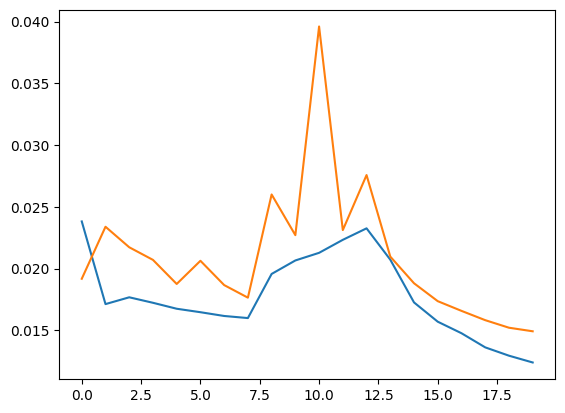

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [30]:
# history.history['val_loss']

In [31]:
# model = get_model()

In [32]:
# str(model_path).format(epoch=20, val_loss=0.02)

In [33]:
# model.load_weights(filepath=str(model_path).format(epoch=20, val_loss=0.02))

In [34]:
# model.compile(
#     loss='mean_squared_error',
#     optimizer=keras.optimizers.Adam(1e-2),
#     metrics=[
#         NotVisiblePrecision(),
#         NotVisibleRecall()
#     ],
#     run_eagerly=False
# )

In [41]:
# model = get_model()

sample_val_images, sample_val_keypoints = next(iter(val_ds))
sample_val_images = sample_val_images
sample_val_keypoints = sample_val_keypoints.numpy()  # .reshape(-1, 38, 2)

predictions = model.predict(sample_val_images)    # .reshape(-1, 38, 2)

1/1 [==============================] - 0s 26ms/step


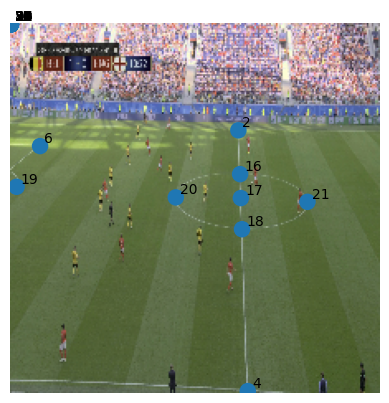

In [42]:
# Ground-truth
vis_utils.show_image_with_annotations(sample_val_images.numpy()[0,:] / 255., sample_val_keypoints[0,:], dot_radius=5)

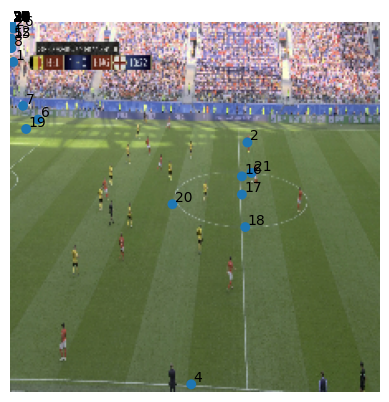

In [43]:
# Predictions
vis_utils.show_image_with_annotations(sample_val_images.numpy()[0,:] / 255., predictions[0], dot_radius=3, normalized=True)

In [ ]:
# Accuracy of predicting visible / invisible

In [38]:
# model.evaluate(x=sample_val_images[:3], y=sample_val_keypoints[:3])

# Performance of a naive model

Is the loss 0.0458 big or small? To understand a bit the magnitude of a loss, let's consider a loss of a model predicting every point to lie in a center of a frame. Or in $(0, 0)$ point.

In [39]:
mse = tf.keras.losses.MeanSquaredError()

In [40]:
y_true = []
for _, y in val_ds:
    y_true.append(y)
    
y_true = np.hstack(y_true)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8 and the array at index 71 has size 6

In [ ]:
y_naive = np.ones((1, 574, 76)) * 0.5
print(mse(y_true, y_naive))

In [ ]:
y_naive = np.ones((1, 574, 76))
print(mse(y_true, y_naive))

In [ ]:
y_naive = np.zeros((1, 574, 76))
print(mse(y_true, y_naive))

It looks as if the most reasonable thing the model can do is to always predict (0, 0)!

I can fight it either with using augmentation that would cuase the upperleft corner to move, or with a different loss function, that would more penalize predict (0, 0) (not visible) if the ground truth keypoint is actually visible. But the first option is easier.